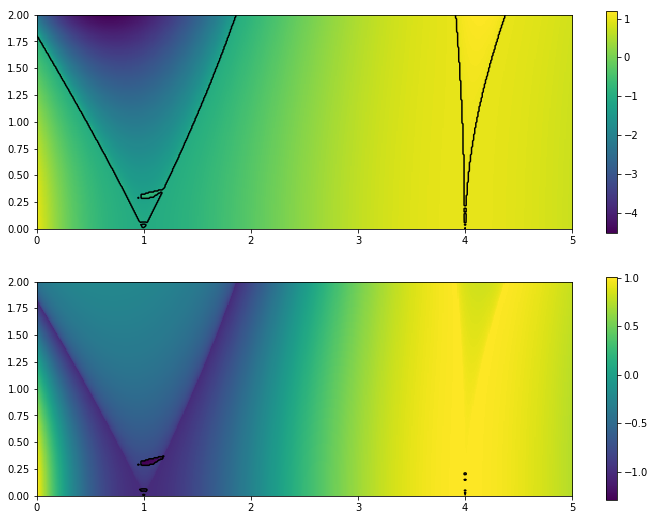

In [47]:
from numpy import cos, arange, linspace, pi, array, empty, meshgrid
from pylab import plot, show, imshow, subplots, rcParams
from scipy.integrate import odeint
from numpy.linalg import eig
%matplotlib inline
rcParams["figure.figsize"] = (12, 9)

def rhs(x, t, delta, eps):
    return [x[1], -(delta+eps*cos(2*t))*x[0]]

Ndelta = 501
Nepsilon = 201
epsilonMin = 0.
epsilonMax = 2.0
deltaMin = 0.
deltaMax = 5.0
deltas = linspace(deltaMin, deltaMax, Ndelta)
epsilons = linspace(epsilonMin, epsilonMax, Nepsilon)
Deltas, Epsilons = meshgrid(deltas, epsilons)
startTime = 0.
endTime = pi
NTimeSteps = 1
time = linspace(startTime, endTime, NTimeSteps + 1)
initX0 = array([1.,0])
initX1 = array([0,1.])
decrements = []
freqs = []
dec2d1 = empty([Nepsilon, Ndelta])
dec2d2 = empty([Nepsilon, Ndelta])
for i in range(Nepsilon):
    for j in range(Ndelta):
        out0 = odeint(rhs, initX0, time, args=(deltas[j], epsilons[i]))
        out1 = odeint(rhs, initX1, time, args=(deltas[j], epsilons[i]))
        M = array([[out0[NTimeSteps,0], out0[NTimeSteps,1]], [out1[NTimeSteps,0], out1[NTimeSteps,1]]])
        multipl, v = eig(M)
        decrements.append(multipl[0].real)
        freqs.append(multipl[1].imag)
        dec2d1[i,j] = multipl[0].real
        dec2d2[i,j] = multipl[1].real
fig, ax = subplots(2,1)
im1 = ax[0].imshow(dec2d1, extent = (deltaMin, deltaMax, epsilonMin, epsilonMax), origin='lower');
fig.colorbar(im1, ax = ax[0])
im2 = ax[1].imshow(dec2d2, extent = (deltaMin, deltaMax, epsilonMin, epsilonMax), origin='lower');
fig.colorbar(im2, ax = ax[1])
cset1 = ax[0].contour(Deltas, Epsilons, dec2d1, (-1,+1), colors='k')
for c in cset1.collections:
    c.set_linestyle('solid')
cset2 = ax[1].contour(Deltas, Epsilons, dec2d2, (-1,+1), colors='k')
for c in cset2.collections:
    c.set_linestyle('solid')
show()

In [108]:
def ComputeMaxMult(delta, eps):
    out0 = odeint(rhs, initX0, time, args=(delta, eps))
    out1 = odeint(rhs, initX1, time, args=(delta, eps))
    M = array([[out0[NTimeSteps,0], out0[NTimeSteps,1]], [out1[NTimeSteps,0], out1[NTimeSteps,1]]])
    multipl, v = eig(M)    
    return max(abs(multipl[0].real), abs(multipl[1].real))
    
def ComputeMultMinus1(delta, eps):
    return ComputeMaxMult(delta, eps)-1.

print(ComputeMultMinus1(0, 1.81))

-0.01316757798935042


In [109]:
def SolveMult(delta, eps):
    x0 = eps
    x1 = 1.01*eps
    f0 = ComputeMultMinus1(delta, x0)
    f1 = ComputeMultMinus1(delta, x1)
    while (abs(x1-x0)>1e-5):
        x0, x1 = x1, (f1*x0-f0*x1)/(f1-f0)
        f0, f1 = f1, ComputeMultMinus1(delta, x1)
    return x1

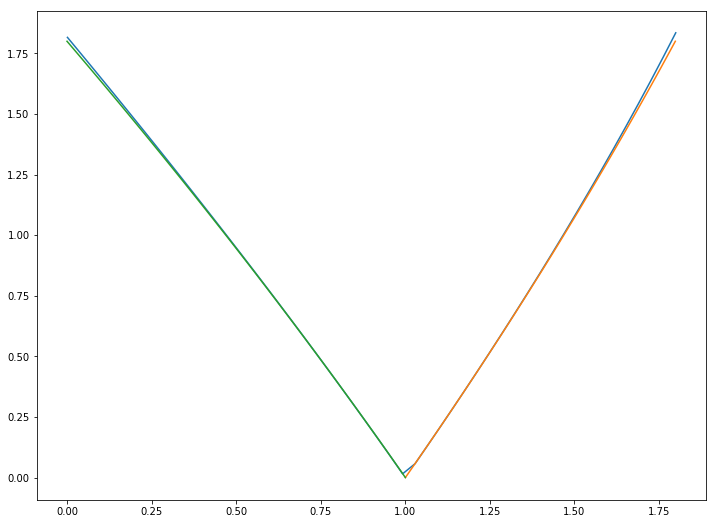

In [124]:
eps = 1.5
deltas = linspace(0,1.8,50)
epsilons = []
for delta in deltas:
    eps = SolveMult(delta, eps)
    epsilons.append(eps)
plot(deltas, epsilons)
e = linspace(0,1.8,50)
plot(1+0.5*e-1./32.*e*e, e)
plot(1-0.5*e-1./32.*e*e, e);